In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# # delete this cell if working on Pycharm
!pip install Bio
!pip install import-ipynb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.9 MB/s eta 0:00:00


In [3]:
%cd "/content/drive/MyDrive/bio_ex3_new/"

/content/drive/MyDrive/bio_ex3_new


In [4]:

import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# so we can import utils notebook (delete if working on Pycharm), you might need to change it to your working directory path

import import_ipynb
import utils

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(140, 22)


In [12]:
###############################################################################
#                                                                             #
#              Parameters you can change, but don't have to                   #
#                                                                             #
###############################################################################


# number of ResNet blocks for the first ResNet and the kernel size.
RESNET_1_BLOCKS = 3
RESNET_1_KERNEL_SIZE = 15
RESNET_1_KERNEL_NUM = 64


###############################################################################
#                                                                             #
#                        Parameters you need to choose                        #
#                                                                             #
###############################################################################


# number of ResNet blocks for the second ResNet, dilation list to repeat and the kernel size.

RESNET_2_BLOCKS = 3
RESNET_2_KERNEL_SIZE = 3  # good start may be 3/5
RESNET_2_KERNEL_NUM = 128
DILATION = [1,2,4,8]

# percentage of dropout for the dropout layer
DROPOUT = 0.25 # good start may be 0.1-0.5

# number of epochs, Learning rate and Batch size
EPOCHS = 20
LR = 0.001 # good start may be 0.0001/0.001/0.01
BATCH = 64 # good start may be 32/64/128

In [13]:
def resnet_1(input_layer):
    """
    ResNet layer - input -> BatchNormalization -> Conv1D -> Relu -> BatchNormalization -> Conv1D -> Relu -> Add
    :param input_layer: input layer for the ResNet
    :return: last layer of the ResNet
    """
    for i in range(RESNET_1_BLOCKS):
        batch_norm_layer = layers.BatchNormalization()(input_layer)
        conv1d_layer = layers.Conv1D(RESNET_1_KERNEL_NUM, RESNET_1_KERNEL_SIZE, activation='relu', padding='same')(batch_norm_layer)
        batch_norm_layer = layers.BatchNormalization()(conv1d_layer)
        input_layer = layers.Conv1D(RESNET_1_KERNEL_NUM, RESNET_1_KERNEL_SIZE, activation='relu', padding='same')(batch_norm_layer) + input_layer
    return input_layer


In [14]:
def resnet_2(input_layer):  # TODO: implement this!
    """
    Dilated ResNet layer - input -> BatchNormalization -> dilated Conv1D -> Relu -> BatchNormalization -> dilated Conv1D -> Relu -> Add
    :param input_layer: input layer for the ResNet
    :return: last layer of the ResNet
    """
    for i in range(RESNET_2_BLOCKS):
        for j in range(len(DILATION)):
            batch_norm_layer = layers.BatchNormalization()(input_layer)
            conv1d_layer = layers.Conv1D(RESNET_2_KERNEL_NUM, RESNET_2_KERNEL_SIZE, dilation_rate=DILATION[j], activation='relu', padding='same')(batch_norm_layer)
            batch_norm_layer = layers.BatchNormalization()(conv1d_layer)
            input_layer = layers.Conv1D(RESNET_2_KERNEL_NUM, RESNET_2_KERNEL_SIZE, dilation_rate=DILATION[j], activation='relu', padding='same')(batch_norm_layer) + input_layer
    return input_layer

In [15]:
def build_network():
    """
    builds the neural network architecture as shown in the exercise.
    :return: a Keras Model
    """
    # input, shape (NB_MAX_LENGTH,FEATURE_NUM)
    input_layer = tf.keras.Input(shape=(utils.NB_MAX_LENGTH, utils.FEATURE_NUM))

    # Conv1D -> shape = (NB_MAX_LENGTH, RESNET_1_KERNEL_NUM)
    conv1d_layer = layers.Conv1D(RESNET_1_KERNEL_NUM, RESNET_1_KERNEL_SIZE, padding='same')(input_layer)

    # first ResNet -> shape = (NB_MAX_LENGTH, RESNET_1_KERNEL_NUM)
    resnet_layer = resnet_1(conv1d_layer)

    # Conv1D -> shape = (NB_MAX_LENGTH, RESNET_2_KERNEL_NUM)
    conv1d_layer = layers.Conv1D(RESNET_2_KERNEL_NUM, RESNET_2_KERNEL_SIZE, padding="same")(resnet_layer)

    # second ResNet -> shape = (NB_MAX_LENGTH, RESNET_2_KERNEL_NUM)
    resnet_layer = resnet_2(conv1d_layer)

    dropout_layer = layers.Dropout(DROPOUT)(resnet_layer)

    conv1d_layer = layers.Conv1D(RESNET_2_KERNEL_NUM // 2, RESNET_2_KERNEL_SIZE, padding="same")(dropout_layer)

    elu_layer = layers.ELU()(conv1d_layer)

    output_layer = layers.Dense(utils.OUTPUT_SIZE)(elu_layer)
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model





In [16]:
def plot_val_train_loss(history):
    """
    plots the train and validation loss of the model at each epoch, saves it in 'model_loss_history.png'
    :param history: history object (output of fit function)
    :return: None
    """
    ig, axes = plt.subplots(1, 1, figsize=(15,3))
    axes.plot(history.history['loss'], label='Training loss')
    axes.plot(history.history['val_loss'], label='Validation loss')
    axes.legend()
    axes.set_title("Train and Val MSE loss")

    plt.savefig("/content/drive/MyDrive/bio_ex3_new/model_loss_history")  # TODO: you can change the path here


In [17]:
!ls

6xw6	 model.keras		 net.ipynb  train_input.npy   utils.ipynb
Ex4Data  model_loss_history.png  README.md  train_labels.npy


Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 50s 676ms/step - loss: 40.6713 - val_loss: 32.8389
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - loss: 5.6174 - val_loss: 24.6101
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 3.4096 - val_loss: 17.7500
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 2.6955 - val_loss: 19.5159
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 2.2962 - val_loss: 13.7855
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 2.0324 - val_loss: 12.7691
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 1.7805 - val_loss: 6.8258
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 1.5820 - val_loss: 5.9646
Epoch 9/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 1.4751 - val_loss: 3.6570
Epoch 10/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 1.3391 - val_loss: 2.6469
Epoch 11/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 1.3079 - val_loss: 1.9118
Epoch 12/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step -

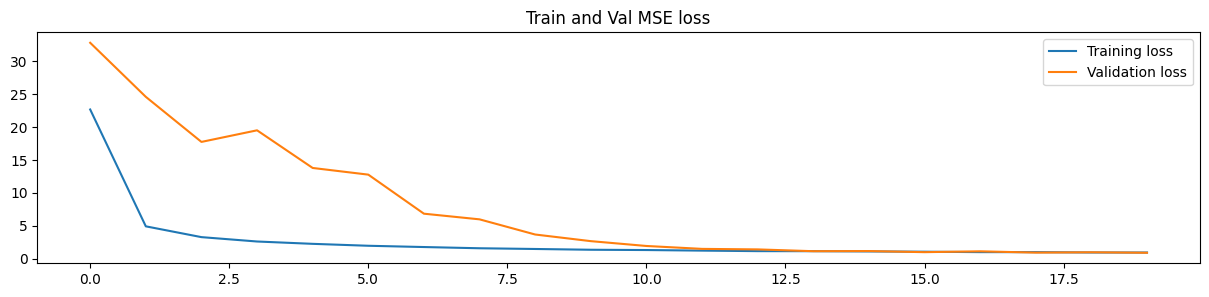

In [18]:
if __name__ == '__main__':

    model = build_network()

    # you can load here your input and output data

    X = np.load("/content/drive/MyDrive/bio_ex3_new/train_input.npy")
    Y = np.load("/content/drive/MyDrive/bio_ex3_new/train_labels.npy")

    # X = numpy array of shape (1974,NB_MAX_LENGTH,FEATURE_NUM) of all the data input.
    # Y = numpy array of shape (1974,NB_MAX_LENGTH,OUTPUT_SIZE) of all the data labels.

    # split into validation and test sets as you like

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # b)
    #  compile model using Adam optimizer (with learning rate of your choice) and MSE loss.
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss='mse')

    # c)
    # fit model (use EPOCH for epoch parameter and BATCH for batch_size parameter)
    history = model.fit(X_train, Y_train, epochs=EPOCHS, batch_size=BATCH, validation_data=(X_test, Y_test))
    plot_val_train_loss(history)

    # d)
    # save model
    model.save("/content/drive/MyDrive/bio_ex3_new/model.keras")


    # part 3 predict




In [19]:
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 140, 22)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 140, 64)   │     21,184 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 140, 64)   │        256 │ conv1d_33[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 140, 64)   │     61,504 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 140, 64)   │        256 │ conv1d_34[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 140, 64)   │     61,504 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 140, 64)   │          0 │ conv1d_35[0][0],  │
│                     │                   │            │ conv1d_33[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 140, 64)   │        256 │ add_15[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 140, 64)   │     61,504 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 140, 64)   │        256 │ conv1d_36[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 140, 64)   │     61,504 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 140, 64)   │          0 │ conv1d_37[0][0],  │
│                     │                   │            │ add_15[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 140, 64)   │        256 │ add_16[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_38 (Conv1D)  │ (None, 140, 64)   │     61,504 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 140, 64)   │        256 │ conv1d_38[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_39 (Conv1D)  │ (None, 140, 64)   │     61,504 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 140, 64)   │          0 │ conv1d_39[0][0],  │
│                     │                   │            │ add_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 140, 128)  │     24,704 │ add_17[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 140, 128)  │        512 │ conv1d_40[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 4,897,391 (18.68 MB)

 Trainable params: 1,630,159 (6.22 MB)

 Non-trainable params: 6,912 (27.00 KB)

 Optimizer params: 3,260,320 (12.44 MB)

None
